### Load Libraries

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

### Loading Churn Dataset

In [3]:
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/dataset/'
file_path = drive_path + 'Telco_customer_churn.csv'
data = pd.read_csv(file_path)
data.head()

Mounted at /content/drive


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
data.shape

(7043, 33)

### Data Preprocessing

In [5]:
#initial data statistics for its its numeric columns
data.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [6]:
#checking data type of the columns in the dataset
dtypes_table = pd.DataFrame(data.dtypes, columns=['Data Type'])
dtypes_table

,Data Type
CustomerID,object
Count,int64
Country,object
State,object
City,object
Zip Code,int64
Lat Long,object
Latitude,float64
Longitude,float64
Gender,object


In [7]:
# Get the list of column names (features) from the 'data'
features = data.columns.tolist()
print(features)

['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason']


In [8]:
# Define a dictionary that maps old payment methods to new payment methods
key_map = {
    'Bank transfer (automatic)': 'Bank transfer',
    'Credit card (automatic)': 'Credit card'
}
data['Payment Method'] = data['Payment Method'].replace(key_map)


In [9]:
# Convert the 'Total Charges' column to numeric values, handling errors by coercing to NaN
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')
total_charges_dtype = data['Total Charges'].dtype
print(total_charges_dtype)

float64


In [10]:
# Calculate the count of missing values for each column in the 'data'
missing_vals_count = data.isnull().sum()
print(missing_vals_count)

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64


In [11]:
# Calculate the percentage of missing values in the 'Total Charges' column
missing_percentage = data['Total Charges'].isnull().mean() * 100

# Calculate the number of neighbors for KNN imputation
n_neighbors = int(round(data.shape[0] ** 0.5))

# Initialise the KNNImputer with the calculated number of neighbors
imputer = KNNImputer(n_neighbors=n_neighbors)

# Use the KNN imputer to fill missing values in the 'Total Charges' column
data['Total Charges'] = imputer.fit_transform(data[['Total Charges']])

In [12]:
# Checking missing values count after imputation
missing_vals_count = data.isnull().sum()
missing_vals_count

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [13]:
# Removing unwanted columns from the 'data'
drop_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label']
data = data.drop(columns=drop_cols)

### Initial Analysis of Customer Churn (EDA)


In [14]:
# List of numeric columns to check for outliers
numeric_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']

# Function to calculate outliers using IQR method
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

for col in numeric_features:
    outliers = find_outliers(data[col])
    print(f'Outliers for {col}:')
    print(outliers)
    print('\n')


Outliers for Tenure Months:
Series([], Name: Tenure Months, dtype: int64)


Outliers for Monthly Charges:
Series([], Name: Monthly Charges, dtype: float64)


Outliers for Total Charges:
Series([], Name: Total Charges, dtype: float64)


Outliers for CLTV:
Series([], Name: CLTV, dtype: int64)




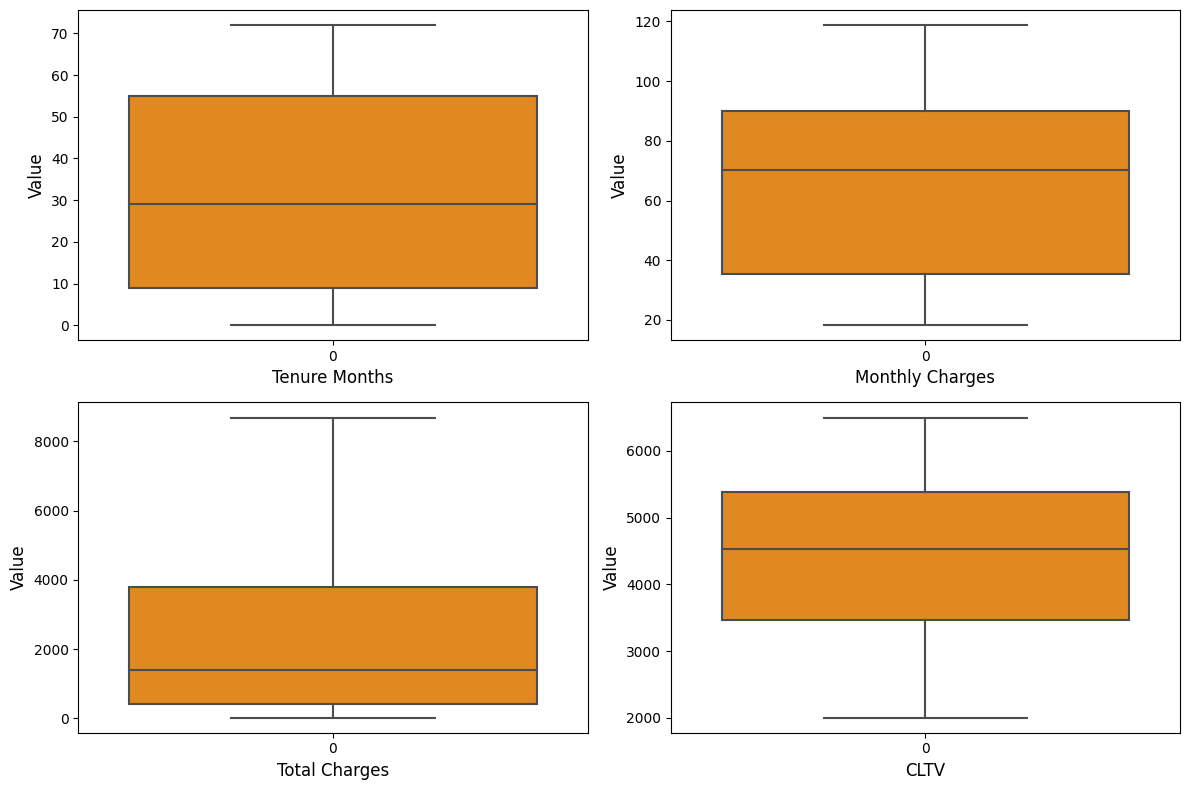

In [15]:
# List of numeric columns to check for outliers
numeric_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data[col], color='darkorange')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Value', fontsize=12)

plt.tight_layout()
plt.show()

Churn Class Distribution:
0    5174
1    1869
Name: Churn Value, dtype: int64

 Churn Class Percentages:
0    73.463013
1    26.536987
Name: Churn Value, dtype: float64


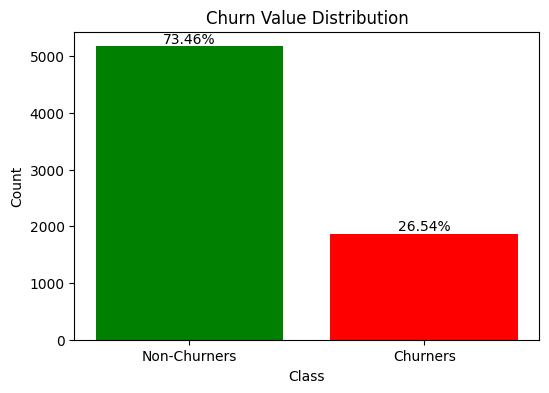

In [19]:
# Checking 'data' for imbalance behaviour

class_counts = data['Churn Value'].value_counts()
total_samples = len(data)
class_percentages = (class_counts / total_samples) * 100
print("Churn Class Distribution:")
print(class_counts)
print("\n Churn Class Percentages:")
print(class_percentages)
bar_colors = ['green', 'red']
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index, class_counts.values, color=bar_colors)
plt.xticks(class_counts.index, labels=['Non-Churners', 'Churners'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Churn Value Distribution')
for bar, percentage in zip(bars, class_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')
plt.show()

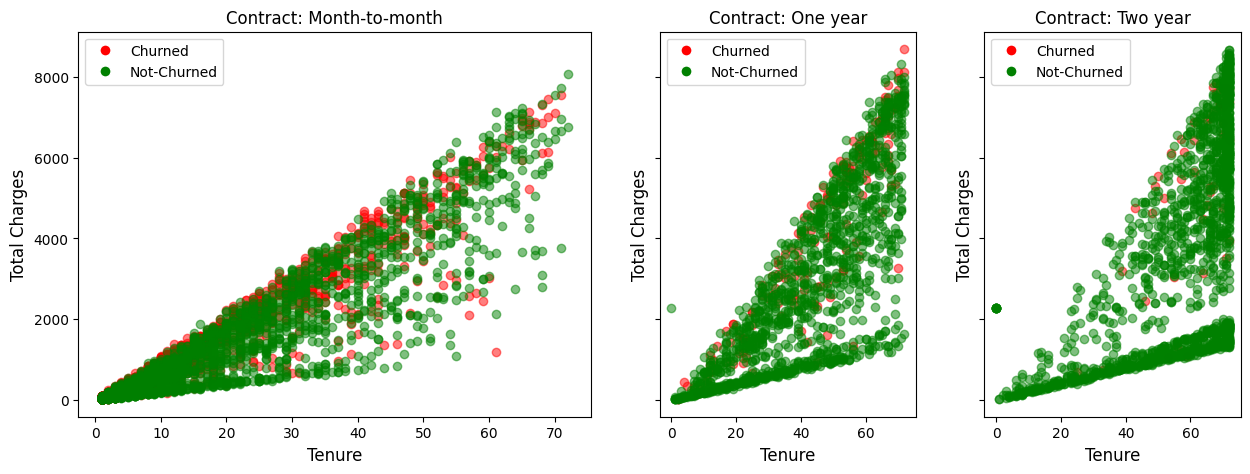

In [20]:
# Create scatter-plots to check the distribution of churn rates over variety of contracts

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, gridspec_kw={'width_ratios': [2, 1, 1]})

contract_order = ['Month-to-month', 'One year', 'Two year']

for contract_type, ax in zip(contract_order, axs):
    contract_data = data[data['Contract'] == contract_type]
    churned = contract_data[contract_data['Churn Value'] == 1]
    not_churned = contract_data[contract_data['Churn Value'] == 0]

    ax.scatter(
        churned['Tenure Months'],
        churned['Total Charges'],
        c='red',
        alpha=0.5,
        label='Churned'
    )

    ax.scatter(
        not_churned['Tenure Months'],
        not_churned['Total Charges'],
        c='green',
        alpha=0.5,
        label='Not-Churned'
    )

    ax.set_title(f'Contract: {contract_type}')
    ax.set_xlabel('Tenure', fontsize=12)
    ax.set_ylabel('Total Charges', fontsize=12)

    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label='Churned', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Not-Churned', markerfacecolor='green', markersize=8)
    ]
    ax.legend(handles=custom_legend)

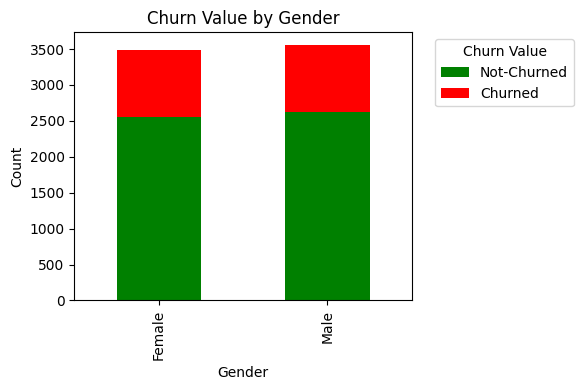

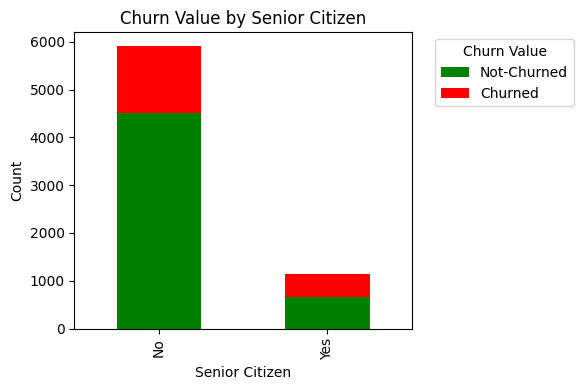

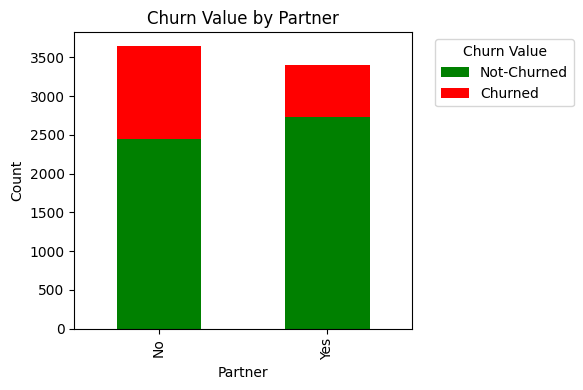

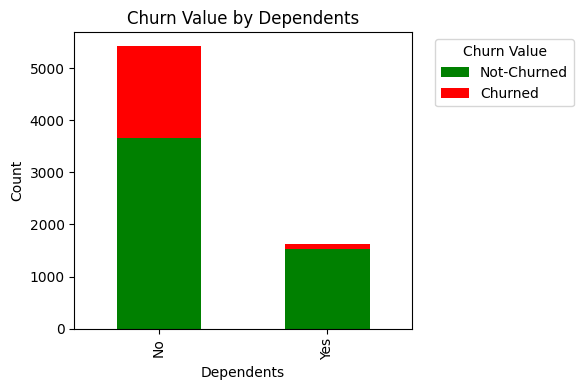

In [24]:
# Relationship of Churn Value with various customer demographics
for feature in ['Gender', 'Senior Citizen', 'Partner', 'Dependents']:
    feature_counts = data.groupby([feature, 'Churn Value']).size().unstack(fill_value=0)
    ax = feature_counts.plot(kind='bar', stacked=True, figsize=(6, 4), color=['green', 'red'])
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    plt.title(f'Churn Value by {feature}')
    plt.legend(title='Churn Value', labels=['Not-Churned', 'Churned'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Feature Selection For Churn Prediction

In [22]:
# New feature generation based on customers paying for add-on services are getting churned or not
columns_to_check = ['Multiple Lines', 'Online Security', 'Device Protection', 'Streaming Movies', 'Tech Support', 'Streaming TV', 'Online Backup']

data['AddOns Count'] = data[columns_to_check].apply(lambda row: row.eq('Yes').sum(), axis=1)
data['AddOns Count'] = data['AddOns Count'].astype(str)

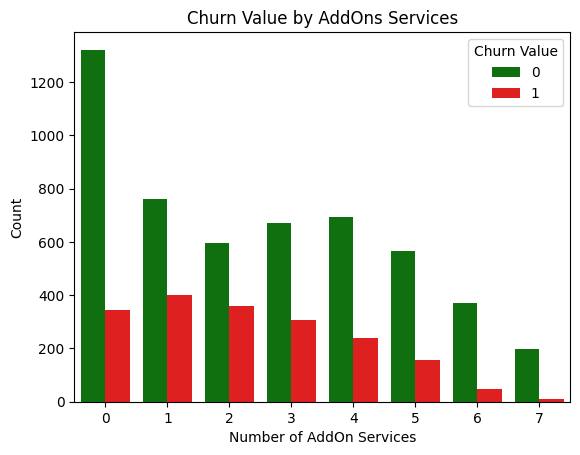

In [25]:
# Compare churn rates for each count of services
sns.countplot(x='AddOns Count', hue='Churn Value', data=data, palette={0: 'green', 1: 'red'},
              order=data['AddOns Count'].value_counts().index.sort_values())
plt.title('Churn Value by AddOns Services')
plt.xlabel('Number of AddOn Services')
plt.ylabel('Count')
plt.show()


### Feature Engineering for Churn Prediction

In [27]:
# Splitting numeric features from 'data'
numeric_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
num_features = data.loc[:, numeric_features]
num_features

,Tenure Months,Monthly Charges,Total Charges,CLTV
0,2,53.85,108.15,3239
1,2,70.70,151.65,2701
2,8,99.65,820.50,5372
3,28,104.80,3046.05,5003
4,49,103.70,5036.30,5340
...,...,...,...,...
7038,72,21.15,1419.40,5306
7039,24,84.80,1990.50,2140
7040,72,103.20,7362.90,5560
7041,11,29.60,346.45,2793


In [28]:
# Scaling the numeric features
scaler = MinMaxScaler( )
scaled_features = scaler.fit_transform(num_features)
num_scaled_features = pd.DataFrame(scaled_features, columns=numeric_features)
num_scaled_features.set_axis(['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV'], axis=1)

,Tenure Months,Monthly Charges,Total Charges,CLTV
0,0.027778,0.354229,0.010310,0.274850
1,0.027778,0.521891,0.015330,0.155215
2,0.111111,0.809950,0.092511,0.749166
3,0.388889,0.861194,0.349325,0.667111
4,0.680556,0.850249,0.578987,0.742050
...,...,...,...,...
7038,1.000000,0.028856,0.161620,0.734490
7039,0.333333,0.662189,0.227521,0.030465
7040,1.000000,0.845274,0.847461,0.790972
7041,0.152778,0.112935,0.037809,0.175673


In [30]:
# T-test for Numeric Features
response = 'Churn Value'

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['Feature', 'T-Statistic', 'P-Value'])

# Perform t-tests for each numeric feature
for feature in num_scaled_features:
    group_0 = data[data[response] == 0][feature]
    group_1 = data[data[response] == 1][feature]

    t_statistic, p_value = ttest_ind(group_0, group_1, equal_var=False)

    results = results.append({'Feature': feature, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Adjust the significance level (alpha) for multiple testing if needed
alpha = 0.05
results['Significant'] = results['P-Value'] < alpha

results.head()

<ipython-input-30-489ea0077873>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': feature, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)
<ipython-input-30-489ea0077873>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': feature, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)
<ipython-input-30-489ea0077873>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': feature, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)
<ipython-input-30-489ea0077873>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

,Feature,T-Statistic,P-Value,Significant
0,Tenure Months,34.823819,1.195495e-232,True
1,Monthly Charges,-18.407527,8.592449e-73,True
2,Total Charges,18.804216,1.100493e-75,True
3,CLTV,10.690830,3.048903e-26,True


In [31]:
# Checking values of categorical features from 'data'

categorical_features = data.select_dtypes(include=['object', 'category'])
for value in categorical_features:
    unique_category = data[value].unique()
    print(f"Unique values in '{value}':")
    print(unique_category)
    print()

Unique values in 'Gender':
['Male' 'Female']

Unique values in 'Senior Citizen':
['No' 'Yes']

Unique values in 'Partner':
['No' 'Yes']

Unique values in 'Dependents':
['No' 'Yes']

Unique values in 'Phone Service':
['Yes' 'No']

Unique values in 'Multiple Lines':
['No' 'Yes' 'No phone service']

Unique values in 'Internet Service':
['DSL' 'Fiber optic' 'No']

Unique values in 'Online Security':
['Yes' 'No' 'No internet service']

Unique values in 'Online Backup':
['Yes' 'No' 'No internet service']

Unique values in 'Device Protection':
['No' 'Yes' 'No internet service']

Unique values in 'Tech Support':
['No' 'Yes' 'No internet service']

Unique values in 'Streaming TV':
['No' 'Yes' 'No internet service']

Unique values in 'Streaming Movies':
['No' 'Yes' 'No internet service']

Unique values in 'Contract':
['Month-to-month' 'Two year' 'One year']

Unique values in 'Paperless Billing':
['Yes' 'No']

Unique values in 'Payment Method':
['Mailed check' 'Electronic check' 'Bank transfer' '

In [32]:
# List of categorical columns to perform one-hot encoding on
cat_features_hoten = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
                      'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
                      'Contract', 'Payment Method', 'AddOns Count', 'Churn Reason']
ohe_features = data.loc[:, cat_features_hoten]


In [33]:
# Getting dummy values using one-hot encoding
ohe_features = pd.get_dummies(ohe_features, columns=cat_features_hoten)
ohe_features

,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,...,Churn Reason_Lack of self-service on Website,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction
0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7039,0,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7040,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7041,0,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# List of categorical columns for label encoding
cat_features_le = ['Senior Citizen', 'Partner', 'Dependents', 'Paperless Billing',
                   'Churn Value', 'Gender', 'Phone Service']

le_features = data.loc[:, cat_features_le]


In [36]:
# Define a function for label encoding
def label_encoding(features, le_features):
    label_encoder = LabelEncoder()  # Initialize the LabelEncoder
    for feature in features:
        le_features[feature] = label_encoder.fit_transform(le_features[feature])  # Perform label encoding
    return

label_encoding(['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing', 'Churn Value'], le_features)

# Replace gender values with numeric labels (Female: 1, Male: 0)
le_features['Gender'] = le_features['Gender'].replace({'Female': 1, 'Male': 0})

In [37]:
# Combining encoded categorical features
en_cat_features = pd.concat([le_features, ohe_features], axis=1)
en_cat_features

,Senior Citizen,Partner,Dependents,Paperless Billing,Churn Value,Gender,Phone Service,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,...,Churn Reason_Lack of self-service on Website,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction
0,0,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7039,0,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7040,0,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7041,0,1,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Applying Chi-Square Test

# Create an empty list to store results
results = []

# Perform chi-squared tests for each encoded feature
for feature in en_cat_features:
    contingency_table = pd.crosstab(en_cat_features[feature], data[response])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    results.append({'Feature': feature, 'Chi2-Statistic': chi2, 'P-Value': p_value})

results_df = pd.DataFrame(results)

# Adjust the significance level (alpha) if needed
alpha = 0.05
results_df['Significant'] = results_df['P-Value'] < alpha

results_df.head(66)


,Feature,Chi2-Statistic,P-Value,Significant
0,Senior Citizen,159.426300,1.510067e-36,True
1,Partner,158.733382,2.139911e-36,True
2,Dependents,433.734379,2.500972e-96,True
3,Paperless Billing,258.277649,4.073355e-58,True
4,Churn Value,7037.871379,0.000000e+00,True
...,...,...,...,...
61,Churn Reason_Poor expertise of online support,49.029618,2.521266e-12,True
62,Churn Reason_Poor expertise of phone support,51.809423,6.115758e-13,True
63,Churn Reason_Price too high,271.315872,5.863045e-61,True
64,Churn Reason_Product dissatisfaction,282.707733,1.929941e-63,True


In [39]:
# Dropping non-significant categorical columns
drop_cols = ['Gender', 'Phone Service', 'AddOns Count_4', 'Multiple Lines_No phone service']
en_cat_features = en_cat_features.drop(columns=drop_cols)

In [40]:
final_data = pd.concat([num_scaled_features, en_cat_features], axis=1)

In [ ]:
# 'final_data ' will be used for model building
final_data.head()

,Tenure Months,Monthly Charges,Total Charges,CLTV,Senior Citizen,Partner,Dependents,Paperless Billing,Churn Value,Multiple Lines_No,...,Churn Reason_Lack of self-service on Website,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction
0,0.027778,0.354229,0.010310,0.274850,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0.027778,0.521891,0.015330,0.155215,0,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
2,0.111111,0.809950,0.092511,0.749166,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
3,0.388889,0.861194,0.349325,0.667111,0,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.680556,0.850249,0.578987,0.742050,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


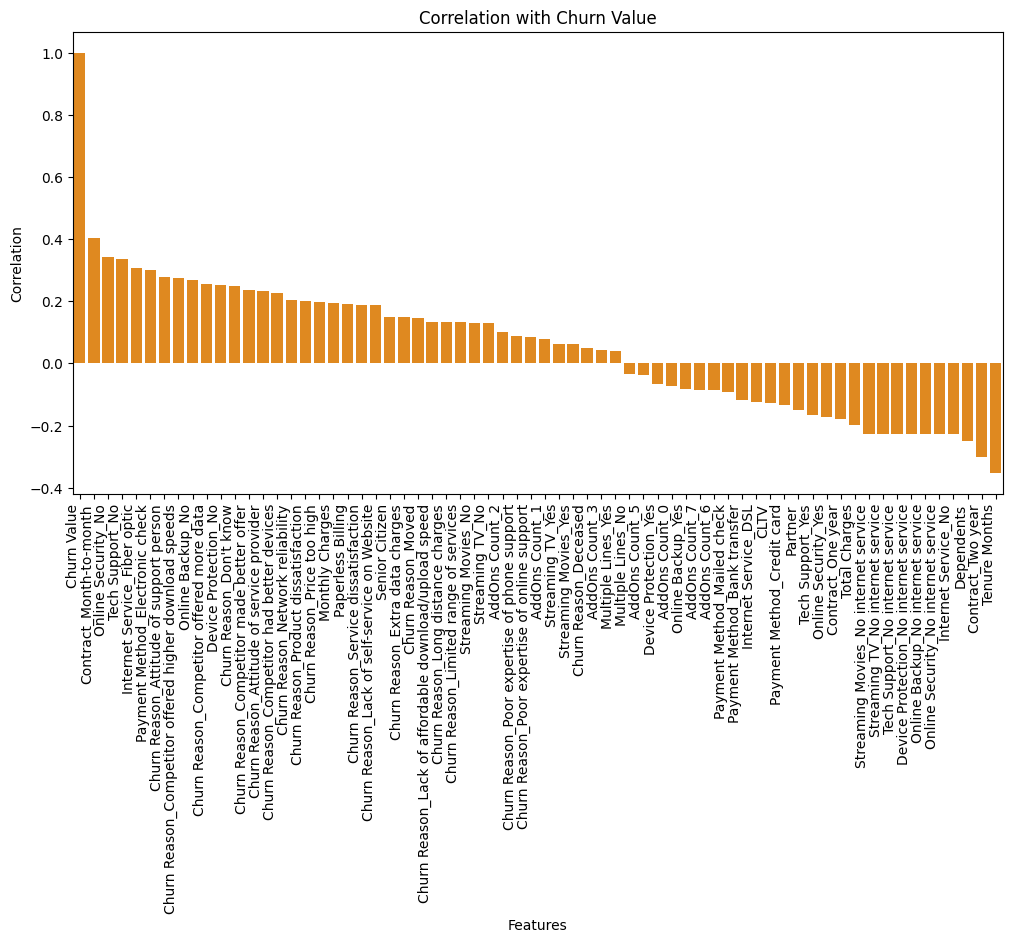

In [41]:
# Calculate the correlation values of selected features with 'Churn Value'

correlation_values = final_data.corr()['Churn Value'].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_values.index, y=correlation_values.values, color='darkorange')
plt.title('Correlation with Churn Value')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90, ha='right')
plt.show()


### Test-train split of final_data

In [49]:
X = final_data.drop('Churn Value', axis=1)
y = final_data['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Borderline-SMOTE to the training data
borderline_smote = BorderlineSMOTE(random_state=42)
X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)

### Model Evaluation Metrics

In [43]:
# Define a function for plotting the confusion matrix

def confusion_matrix_plot(X_resampled, y_resampled, y_test, y_pred, model):
    target_names = ['Non-churn', 'Churn']

    conf_matrix = confusion_matrix(y_test, y_pred)

    conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

    accuracy = accuracy_score(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Test Data')
    plt.show()

    print(f'Train Set Accuracy: {model.score(X_resampled, y_resampled)}')
    print(f"Test Set Accuracy: {accuracy:.2f}\n")
    return conf_matrix_df

In [45]:
# Define a function that plots the feature weights for logistic regression

def feature_importance(data, classifier, classifier_name):
    weights = pd.Series(classifier.coef_[0], index=data.columns.values).sort_values(ascending=False)
    top_weights_selected = weights[:20]
    bottom_weights_selected = weights[-20:]

    # Set up plot style and color
    plt.style.use('ggplot')
    color = 'darkorange'

    # Plot top 10 features with dark orange bars
    plt.figure(figsize=(7, 6))
    plt.tick_params(labelsize=10)
    plt.title(f'{classifier_name} - Top Features')
    top_weights_selected.plot(kind="bar", color=color)
    plt.show()

    # Plot bottom 10 features with dark orange bars
    plt.figure(figsize=(7, 6))
    plt.tick_params(labelsize=10)
    plt.title(f'{classifier_name} - Bottom Features')
    bottom_weights_selected.plot(kind="bar", color=color)
    plt.show()



In [46]:
# Define a function that plots the ROC curve and the AUC score

def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
    y_pred_prob = y_pred_probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=classifier_name, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.legend()
    plt.show()

    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f'AUC Score (ROC): {auc_score}\n')


In [47]:
# Define a function that plots the precision-recall-curve and the F1 score and AUC score

def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
    y_pred_prob = y_pred_probabilities[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall, precision, color='darkorange', label=classifier_name)  # Change the line color to orange
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} - Precision-Recall Curve')
    plt.legend()
    plt.show()

    f1_score_result = f1_score(y_test, y_pred)
    auc_score_result = auc(recall, precision)
    return print(f'F1 Score: {f1_score_result}\nAUC Score (PR): {auc_score_result}\n')

### Model Training and Model Selection

##### Logistic Regression

In [50]:
lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [51]:
# Evaluation Metrics for Logistic Regression Model
y_pred_lg_model = lg_model.predict(X_test)
y_pred_lg_model_pb = lg_model.predict_proba(X_test)

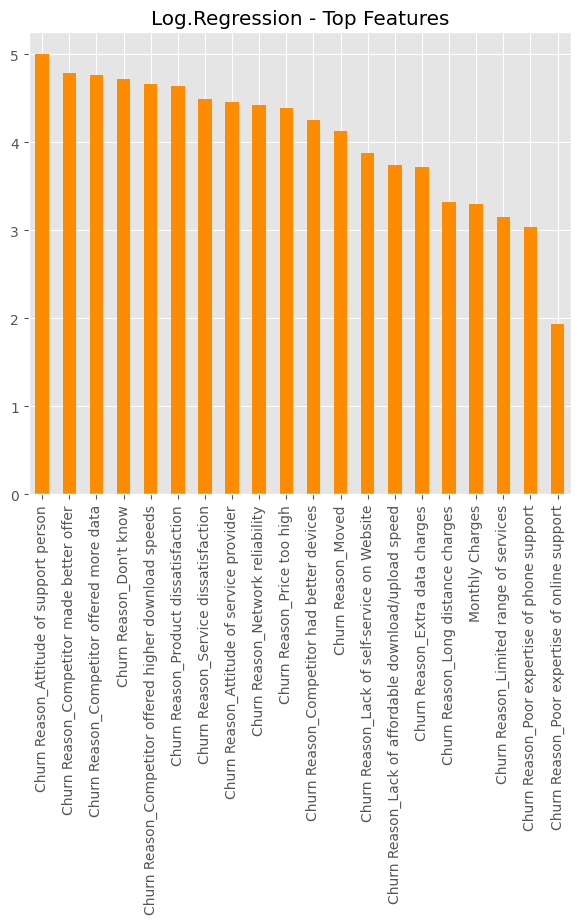

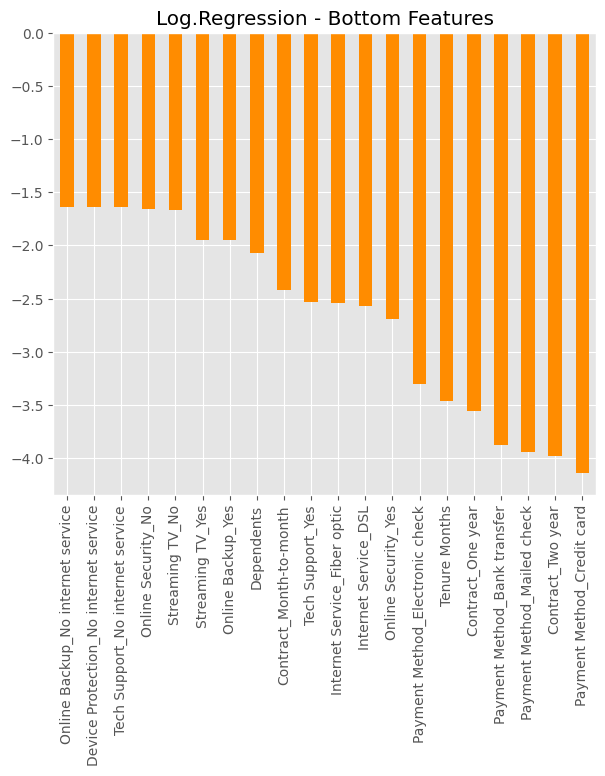

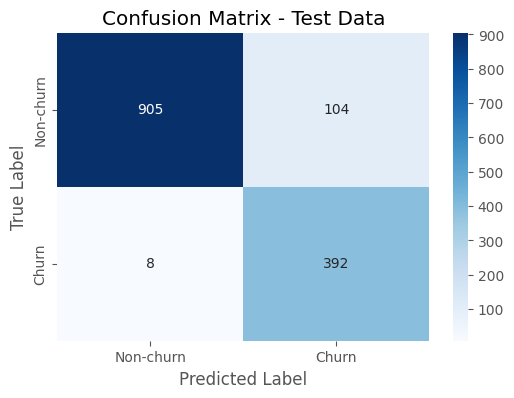

Train Set Accuracy: 0.9177671068427371
Test Set Accuracy: 0.92

           Non-churn  Churn
Non-churn        905    104
Churn              8    392


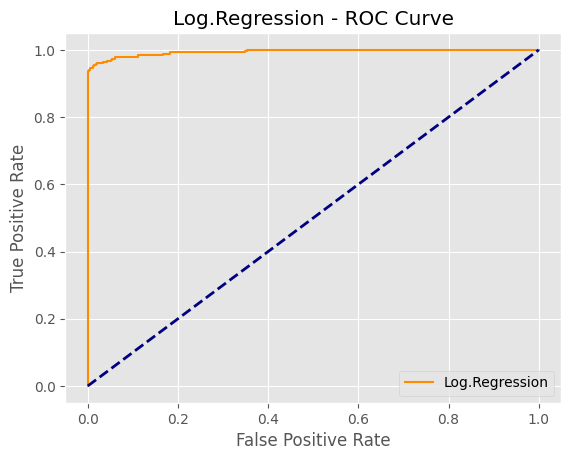

AUC Score (ROC): 0.9944970267591674



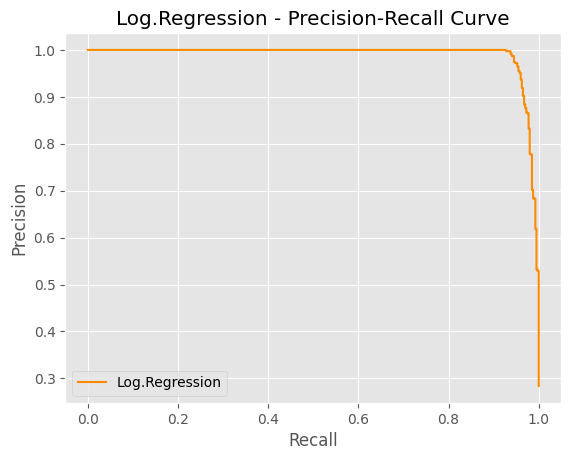

F1 Score: 0.8749999999999999
AUC Score (PR): 0.9903153741265002



In [52]:
feature_importance(X, lg_model, 'Log.Regression')
conf_mat = confusion_matrix_plot(X_resampled, y_resampled, y_test, y_pred_lg_model, lg_model)
print(conf_mat)
roc_curve_auc_score(X_test, y_test, y_pred_lg_model_pb, 'Log.Regression')
precision_recall_curve_and_scores(X_test, y_test, y_pred_lg_model, y_pred_lg_model_pb, 'Log.Regression')

##### K Nearest Neigbhor Classifier

In [55]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_resampled, y_resampled)

KNeighborsClassifier()

In [56]:
# Evaluation Metrics for KNN Model
y_pred_knn_model = knn_model.predict(X_test)
y_pred_knn_model_pb = knn_model.predict_proba(X_test)

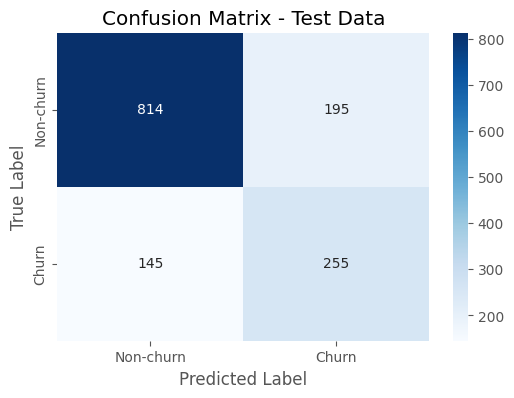

Train Set Accuracy: 0.9002400960384154
Test Set Accuracy: 0.76

           Non-churn  Churn
Non-churn        814    195
Churn            145    255


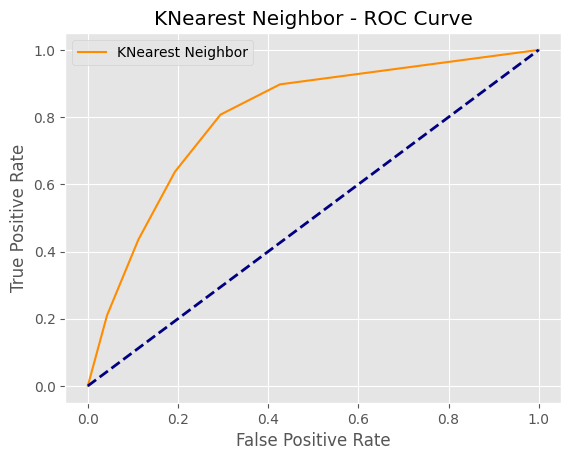

AUC Score (ROC): 0.800263875123885



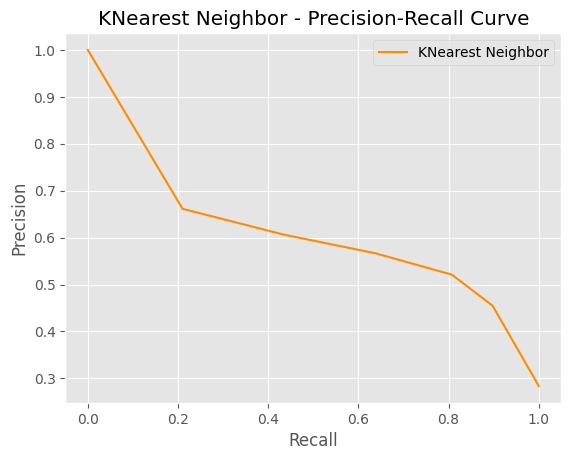

F1 Score: 0.6
AUC Score (PR): 0.6100600188815652



In [57]:
conf_mat = confusion_matrix_plot(X_resampled, y_resampled, y_test, y_pred_knn_model, knn_model)
print(conf_mat)
roc_curve_auc_score(X_test, y_test, y_pred_knn_model_pb, 'KNearest Neighbor')
precision_recall_curve_and_scores(X_test, y_test, y_pred_knn_model, y_pred_knn_model_pb, 'KNearest Neighbor')

##### Random Forest Classifier

In [58]:
rf_model = RandomForestClassifier ()
# No SMOTE as random forest has ability to deal with imbalance dataset
rf_model.fit (X_train, y_train)

RandomForestClassifier()

In [59]:
# Evaluation Metrics for random forest Model
y_pred_rf_model = rf_model.predict (X_test)
y_pred_rf_model_pb = rf_model.predict_proba(X_test)

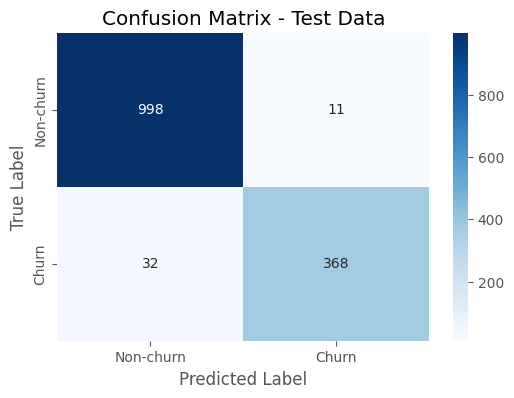

Train Set Accuracy: 1.0
Test Set Accuracy: 0.97

           Non-churn  Churn
Non-churn        998     11
Churn             32    368


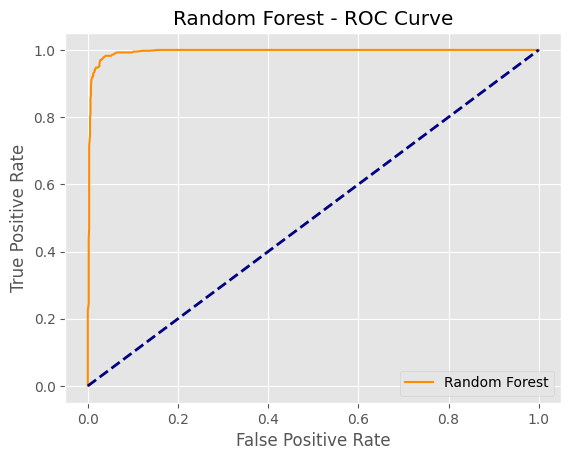

AUC Score (ROC): 0.9947286917740337



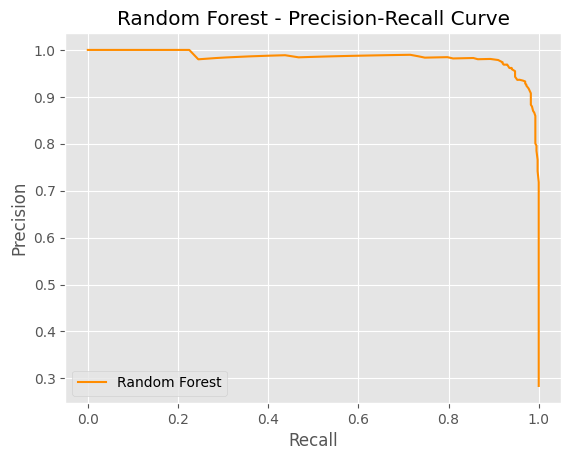

F1 Score: 0.944801026957638
AUC Score (PR): 0.9833553320177219



In [60]:
# Plot model evaluations.
conf_mat = confusion_matrix_plot(X_train, y_train, y_test, y_pred_rf_model,rf_model)
print(conf_mat)
roc_curve_auc_score(X_test, y_test, y_pred_rf_model_pb, 'Random Forest')
precision_recall_curve_and_scores(X_test, y_test, y_pred_rf_model, y_pred_rf_model_pb, 'Random Forest')

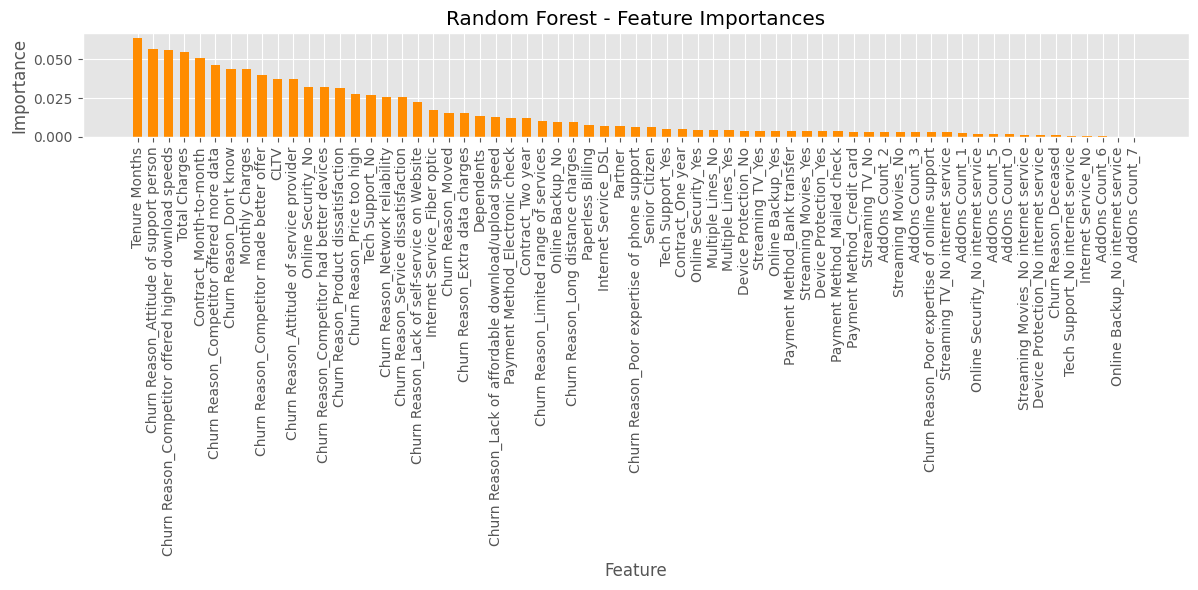

Selected Features:
['Tenure Months', 'Churn Reason_Attitude of support person', 'Churn Reason_Competitor offered higher download speeds', 'Total Charges', 'Contract_Month-to-month', 'Churn Reason_Competitor offered more data', "Churn Reason_Don't know", 'Monthly Charges', 'Churn Reason_Competitor made better offer', 'CLTV', 'Churn Reason_Attitude of service provider', 'Online Security_No', 'Churn Reason_Competitor had better devices', 'Churn Reason_Product dissatisfaction', 'Churn Reason_Price too high', 'Tech Support_No', 'Churn Reason_Network reliability', 'Churn Reason_Service dissatisfaction', 'Churn Reason_Lack of self-service on Website']


In [63]:
# Get feature importances for random forest
importances = rf_model.feature_importances_

feature_importances_series = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), feature_importances_series, color='darkorange', align='center', width=0.6)
plt.xticks(range(X.shape[1]), feature_importances_series.index, rotation=90)
plt.title('Random Forest - Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Create a new dataframe with features having importance > 0.02
selected_features = feature_importances_series[feature_importances_series > 0.02].index
X_rf = X[selected_features]

print("Selected Features:")
print(X_rf.columns.tolist())

##### Support Vector Classifier

In [66]:
# Apply SVC using 'rbf' kernel
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_resampled, y_resampled)

SVC(probability=True)

In [67]:
# Evaluation metrics for SVC model
y_pred_svm_model = svm_model.predict(X_test)
y_pred_svm_model_pb = svm_model.predict_proba(X_test)

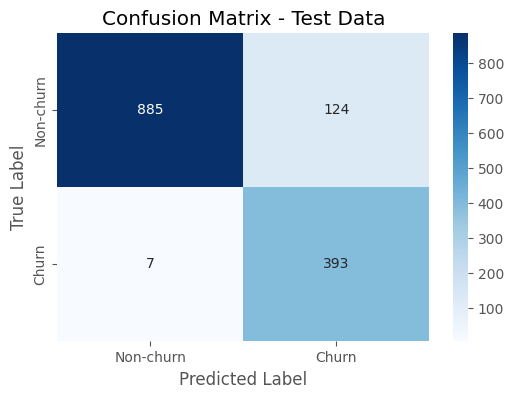

Train Set Accuracy: 0.9297719087635054
Test Set Accuracy: 0.91

           Non-churn  Churn
Non-churn        885    124
Churn              7    393


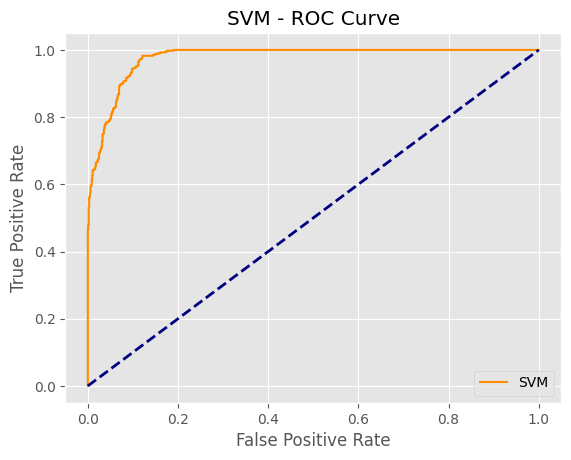

AUC Score (ROC): 0.9767765113974232



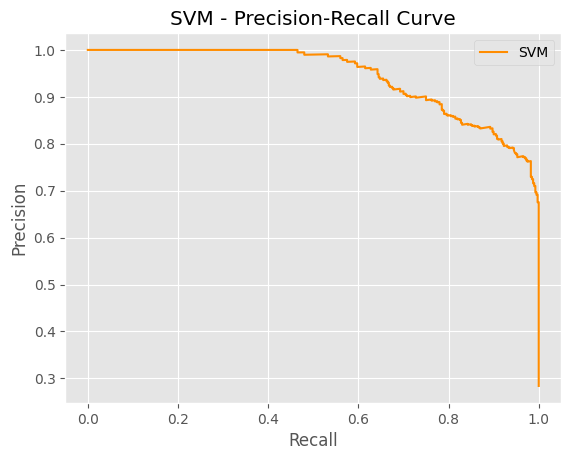

F1 Score: 0.8571428571428572
AUC Score (PR): 0.9429635586907813



In [68]:
conf_mat = confusion_matrix_plot(X_resampled, y_resampled, y_test, y_pred_svm_model, svm_model)
print(conf_mat)
roc_curve_auc_score(X_test, y_test, y_pred_svm_model_pb, 'SVM')
precision_recall_curve_and_scores(X_test, y_test, y_pred_svm_model, y_pred_svm_model_pb, 'SVM')

### Traditional Model Comparison using Cross-Validation (K-Fold)

In [69]:
# Creating a list of models for comparision
models = []
models.append(('Logistic Regression', lg_model))
models.append(('K Nearest Neigbhors', knn_model))
models.append(('Random Forest',rf_model))
models.append(('SVM', svm_model))

In [70]:
# Declare results list for accuracies
acc_results = []
auc_results = []
train_acc_results = []
names = []

col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD',
       'Train Accuracy Mean',
       'Test Accuracy Mean']
model_results = pd.DataFrame(columns=col)
i = 0

# using k-fold cross-validation:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=None)

    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train,
                                                     cv=kfold,
                                                     scoring='accuracy')

    # train accuracy scoring:
    cv_train_acc_results = model_selection.cross_val_score(model, X_train, y_train,
                                                           cv=kfold,
                                                           scoring='accuracy')

    # test accuracy scoring:
    cv_test_acc_results = model_selection.cross_val_score(model, X_test, y_test,
                                                          cv=kfold,
                                                          scoring='accuracy')

    # roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    train_acc_results.append(cv_train_acc_results)
    names.append(name)

    model_results.loc[i] = [name,
                             round(cv_auc_results.mean()*100, 2),
                             round(cv_auc_results.std()*100, 2),
                             round(cv_train_acc_results.mean()*100, 2),
                             round(cv_test_acc_results.mean()*100, 2)
                            ]
    i += 1

model_results = model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

In [71]:
model_results

,Algorithm,ROC AUC Mean,ROC AUC STD,Train Accuracy Mean,Test Accuracy Mean
0,Logistic Regression,100.00,0.00,99.88,98.37
3,SVM,100.00,0.00,99.95,96.81
2,Random Forest,99.52,0.20,96.34,88.43
1,K Nearest Neigbhors,78.57,3.04,77.83,76.16


### Traditional Models Optimisation

##### Logistic Regression Optimisation Using L1 and L2 Regularisation

In [72]:
lg_model_tuned = LogisticRegression(max_iter=1000)

# Define the hyperparameter search space
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga']
}
# Create the GridSearchCV object
grid_search = GridSearchCV(lg_model_tuned, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
lg_best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_lg_model_tuned = lg_best_model.predict(X_test)
y_pred_lg_model_tuned_pb = lg_best_model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred_lg_model_tuned)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)

Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
Test Accuracy: 0.9347054648687012


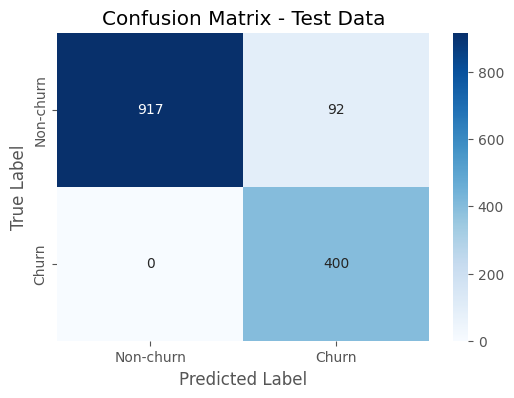

Train Set Accuracy: 0.9236494597839136
Test Set Accuracy: 0.93



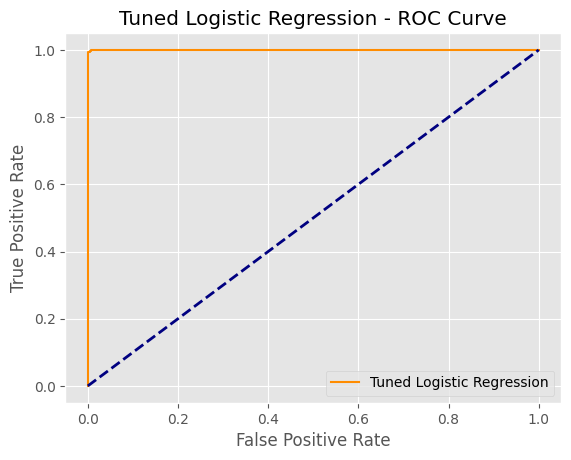

AUC Score (ROC): 0.9999727452923687



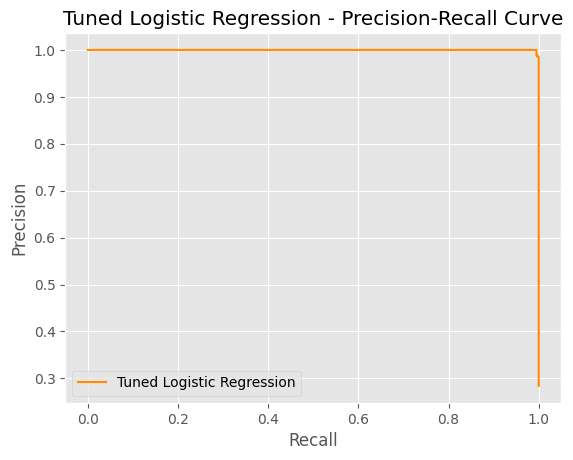

F1 Score: 0.8968609865470852
AUC Score (PR): 0.9999320295931843



In [73]:
# Evaluation metrics for tuned logistic regression model
confusion_matrix_plot(X_resampled, y_resampled, y_test, y_pred_lg_model_tuned, lg_best_model)
roc_curve_auc_score(X_test, y_test, y_pred_lg_model_tuned_pb, 'Tuned Logistic Regression')
precision_recall_curve_and_scores(X_test, y_test, y_pred_lg_model_tuned, y_pred_lg_model_tuned_pb, 'Tuned Logistic Regression')


##### Random Forest Optimisation

In [76]:
# Decrease features based on feature selection done: "X_rf"
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

In [77]:
# Create a Random Forest classifier
rf_model_tuned = RandomForestClassifier()

# Define the hyperparameter search space
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf_model_tuned, param_distributions, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the random search on the training data with selected features
random_search.fit(X_train_rf, y_train_rf)

# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
rf_best_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred_rf_model_tuned = rf_best_model.predict(X_test_rf)
y_pred_rf_model_tuned_pb = rf_best_model.predict_proba(X_test_rf)
accuracy = accuracy_score(y_test, y_pred_rf_model_tuned)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)

Best Hyperparameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}
Test Accuracy: 0.9531582682753726


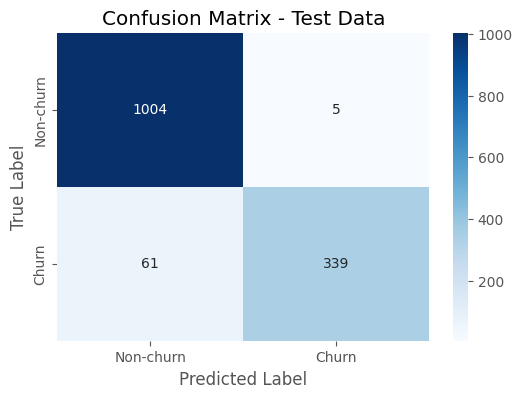

Train Set Accuracy: 0.9692935747248846
Test Set Accuracy: 0.95



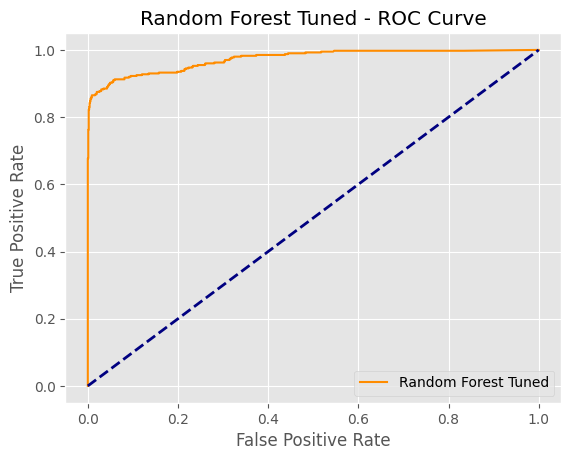

AUC Score (ROC): 0.972986868186323



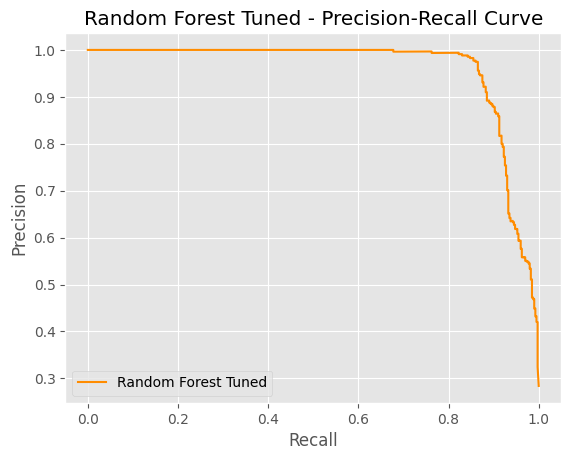

F1 Score: 0.9112903225806452
AUC Score (PR): 0.9591916400725634



In [78]:
# Evaluation metrics for tuned random forest model
confusion_matrix_plot(X_train_rf, y_train_rf, y_test, y_pred_rf_model_tuned, rf_best_model)
roc_curve_auc_score(X_test, y_test, y_pred_rf_model_tuned_pb, 'Random Forest Tuned')
precision_recall_curve_and_scores(X_test, y_test, y_pred_rf_model_tuned, y_pred_rf_model_tuned_pb, 'Random Forest Tuned')

##### SVM Optimisation

In [79]:
svm_model_tuned = SVC()

# Define the hyperparameters to search over
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(svm_model_tuned, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
svm_best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_svm_model_tuned = svm_best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm_model_tuned)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)

Best Hyperparameters: {'C': 1000.0, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy: 0.9304471256210078


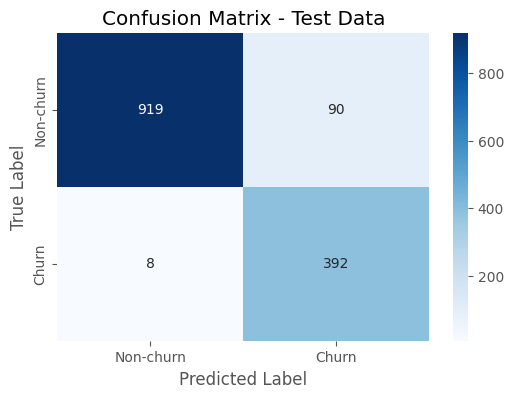

Train Set Accuracy: 0.9510204081632653
Test Set Accuracy: 0.93



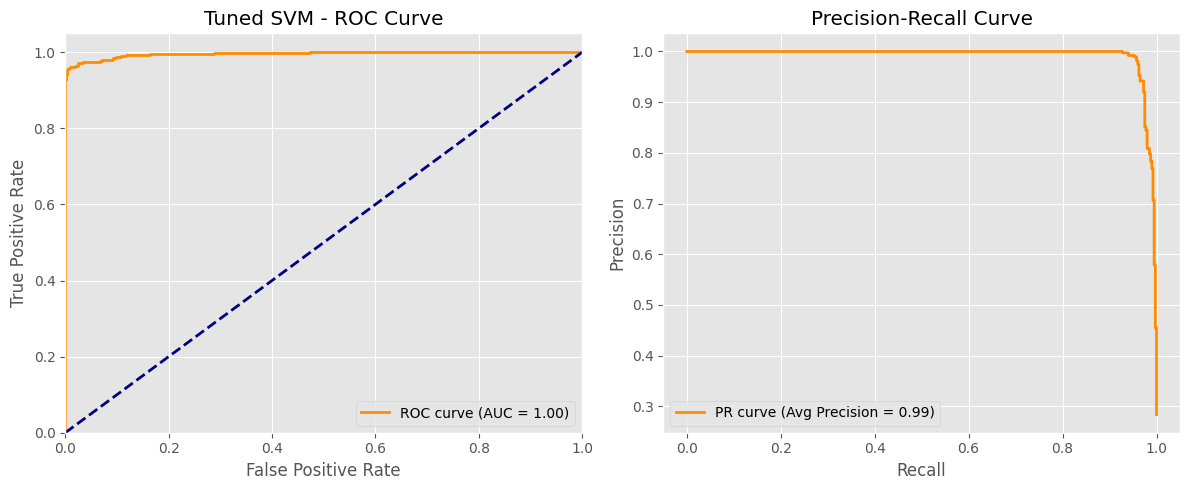

F1 Score: 0.8888888888888888


In [82]:
# Evaluation metrics for tuned SVC model

confusion_matrix_plot(X_resampled, y_resampled, y_test, y_pred_svm_model_tuned, svm_best_model)

def plot_roc_pr_curves(model, X_test, y_test):
    # Get decision function scores
    decision_scores = model.decision_function(X_test)

    # Compute ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_test, decision_scores)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_test, decision_scores)
    average_precision = average_precision_score(y_test, decision_scores)
    f1_score_result = f1_score(y_test, y_pred_svm_model_tuned)
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Tuned SVM - ROC Curve')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (Avg Precision = {:.2f})'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()
    print(f'F1 Score: {f1_score_result}')
# Assuming svm_best_model, X_test, and y_test are already defined
plot_roc_pr_curves(svm_best_model, X_test, y_test)


##### Feed Forward Neural Network

In [83]:
# Define the model architecture
def create_model():
    model = Sequential([
        layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001), input_dim=X_resampled.shape[1], activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.0001, decay_steps=(X_resampled.shape[0] / 32) * 50, decay_rate=1, staircase=False)

# Define the optimiser
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# Define the callbacks
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=70, restore_best_weights=True)]

# Create and compile the model
nn_model2 = create_model()
nn_model2.compile(loss='binary_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])

# Display the model summary
nn_model2.summary()

# Convert data types
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Fit the model
history = nn_model2.fit(X_resampled, y_resampled, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=get_callbacks(), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4224      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
261/261 [==============================] -

<ipython-input-84-aa403332859a>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', color='#c14953', label='Validation Acc: {:.4f}'.format(val_acc[-1]))
<ipython-input-84-aa403332859a>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='#c14953', label='Validation Loss: {:.4f}'.format(val_loss[-1]))


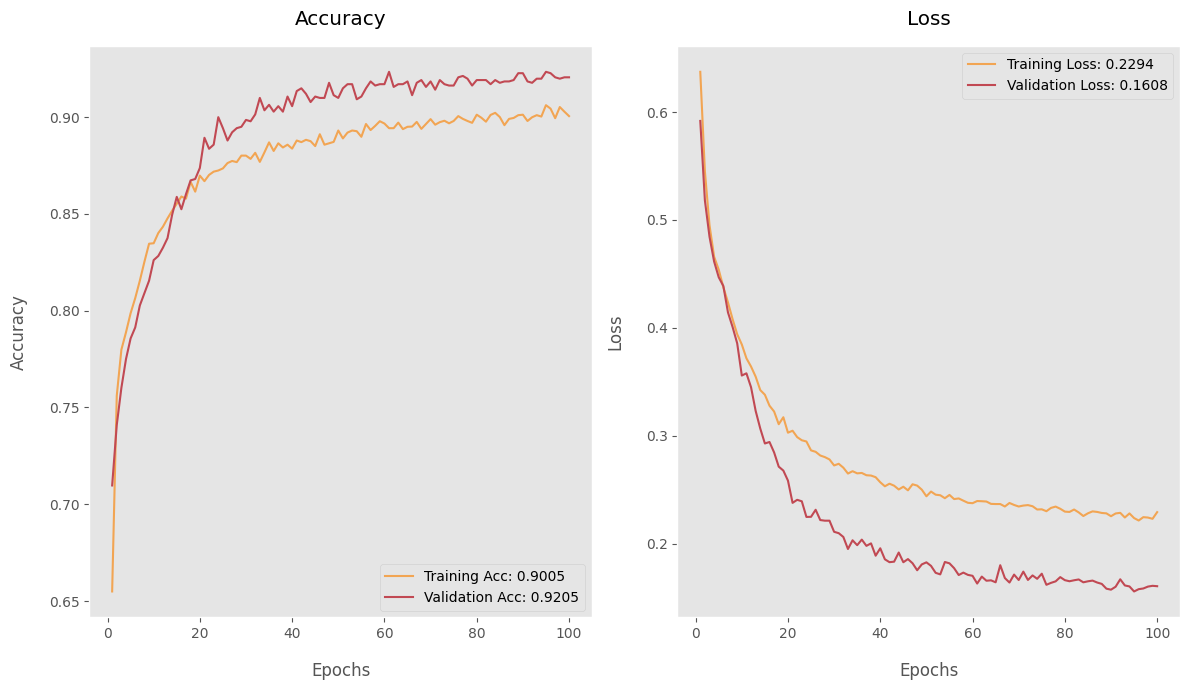

In [84]:
# Extracting training and validation metrics from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# Create a figure with subplots for accuracy and loss
plt.figure(figsize=(12, 7))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color='#f2a553', label='Training Acc: {:.4f}'.format(acc[-1]))
plt.plot(epochs, val_acc, 'b', color='#c14953', label='Validation Acc: {:.4f}'.format(val_acc[-1]))
plt.title('Accuracy', pad=15)
plt.grid(False)
plt.xlabel('Epochs', labelpad=15)
plt.ylabel('Accuracy', labelpad=15)
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color='#f2a553', label='Training Loss: {:.4f}'.format(loss[-1]))
plt.plot(epochs, val_loss, 'b', color='#c14953', label='Validation Loss: {:.4f}'.format(val_loss[-1]))
plt.title('Loss', pad=15)
plt.grid(False)
plt.xlabel('Epochs', labelpad=15)
plt.ylabel('Loss', labelpad=15)
plt.legend()
plt.tight_layout()
plt.show()

45/45 [==============================] - 0s 2ms/step


<ipython-input-86-a3af47dd70fb>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linewidth=1.0, color="navy")  # Dashed diagonal line


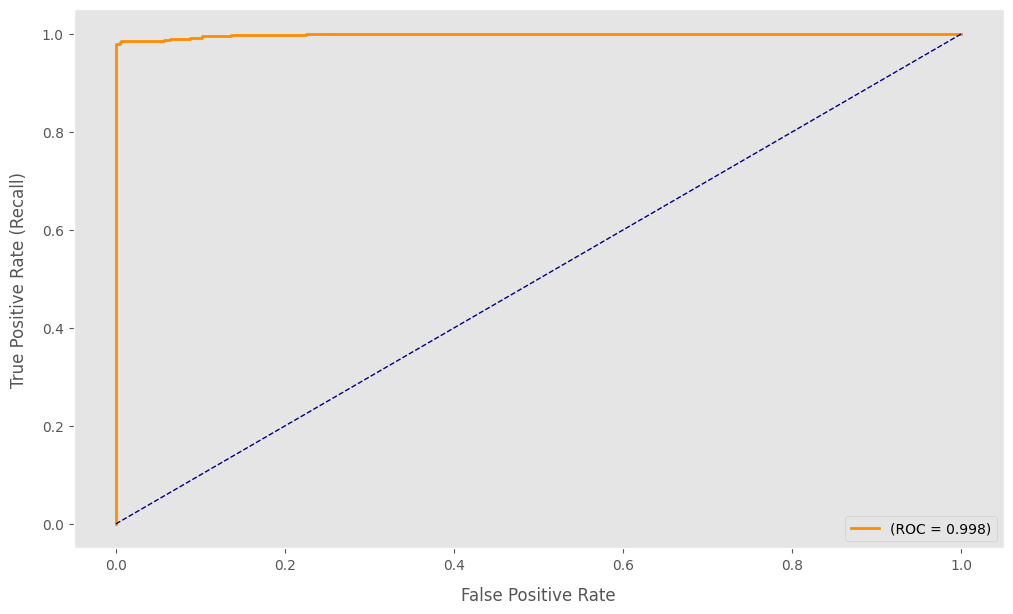

In [86]:
# Make predictions for the test dataset

X_test_nn = X_test.to_numpy()
X_test_nn_p = X_test_nn.reshape(1409, 65)

yprednn_r_test = nn_model2.predict(X_test_nn_p)

# Calculate ROC Curve Input for the Neural Network
y_scores_nn = yprednn_r_test
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_scores_nn)

# Plot ROC Curve
plt.figure(figsize=(12, 7))

def plot_roc_curve(fpr, tpr, label=None, color=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, color=color)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.0, color="navy")  # Dashed diagonal line
    plt.xlabel('False Positive Rate', labelpad=10)
    plt.ylabel('True Positive Rate (Recall)', labelpad=10)
    plt.legend(loc="lower right")
    plt.grid(False)

# Call the function to plot the ROC curve
plot_roc_curve(fpr_nn, tpr_nn, "(ROC = %0.3f)" % (roc_auc_score(y_test, y_scores_nn)), "#ff8c00")

# Display the plot
plt.show()


### Profit Maximisation from Churn Rate Groups

##### Customer Segmentation

In [87]:
# Predict churn using the Tuned Random Forest model
churn_pred = rf_best_model.predict(X_rf)

# Create a dataframe for churn predictions
churn_pred_data = pd.DataFrame(churn_pred, columns=["Churn Value"])

# Define churn rate categories based on prediction values
churn_rate_categories = []
for churn_value in churn_pred:
    if churn_value >= 0.6:
        churn_rate_categories.append("high")
    else:
        churn_rate_categories.append("low")

# Create a dataframe for churn rate categories
churn_pred_category = pd.DataFrame(churn_rate_categories, columns=["Churn Rate Category"])

# Concatenate the original data, churn predictions, and churn rate categories
churn_pred_i = pd.concat([X, churn_pred_data, churn_pred_category], axis=1)

churn_pred_i.head(10)


,Tenure Months,Monthly Charges,Total Charges,CLTV,Senior Citizen,Partner,Dependents,Paperless Billing,Multiple Lines_No,Multiple Lines_Yes,...,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction,Churn Value,Churn Rate Category
0,0.027778,0.354229,0.010310,0.274850,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,high
1,0.027778,0.521891,0.015330,0.155215,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,low
2,0.111111,0.809950,0.092511,0.749166,0,0,1,1,0,1,...,0,1,0,0,0,0,0,0,0,low
3,0.388889,0.861194,0.349325,0.667111,0,1,1,1,0,1,...,0,1,0,0,0,0,0,0,0,low
4,0.680556,0.850249,0.578987,0.742050,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,high
5,0.138889,0.367662,0.058799,0.872137,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,high
6,0.013889,0.212935,0.002406,0.762731,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,high
7,0.013889,0.018905,0.000156,0.629086,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,high
8,0.652778,0.806965,0.545852,0.841895,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,high
9,0.013889,0.118905,0.001315,0.202802,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,high


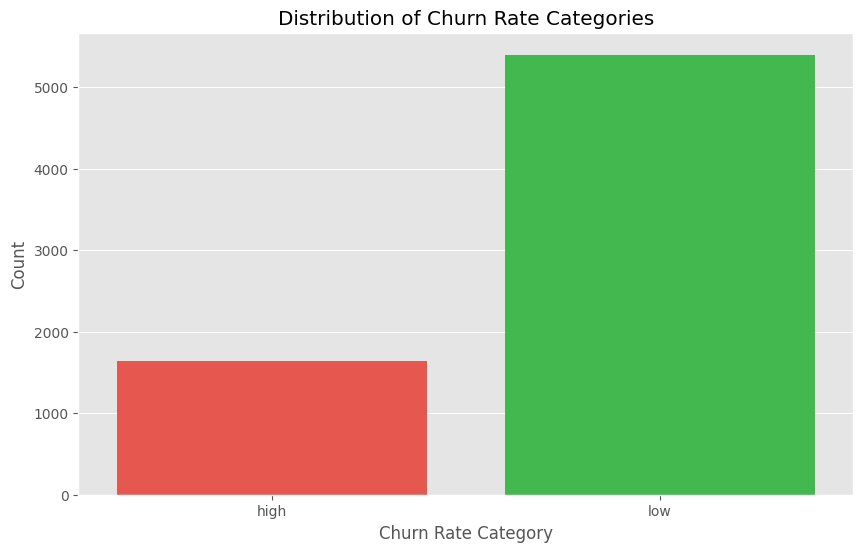

In [88]:
# Plot the distribution of churn rate categories
colors = ["#ff4136", "#2ecc40"]

plt.figure(figsize=(10, 6))
sns.countplot(data=churn_pred_i, x="Churn Rate Category", palette=colors)
plt.title("Distribution of Churn Rate Categories")
plt.xlabel("Churn Rate Category")
plt.ylabel("Count")
plt.show()

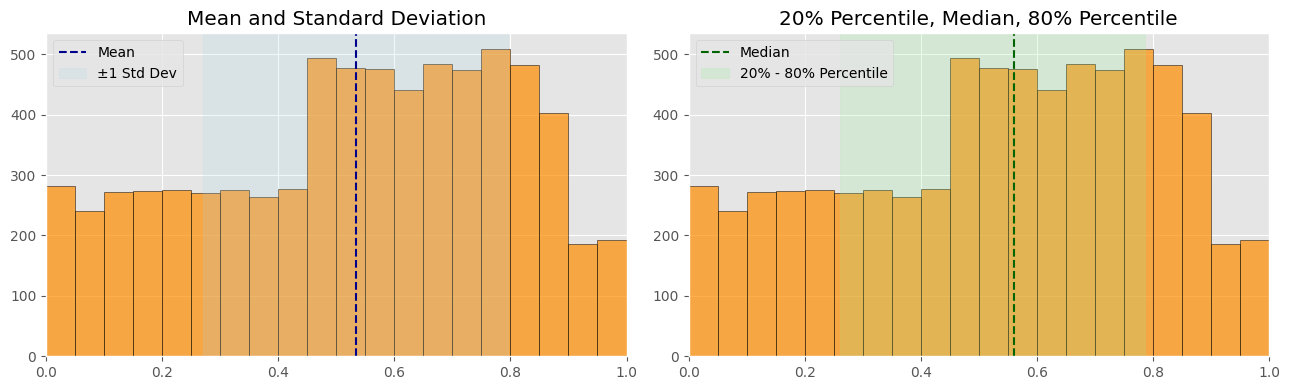

In [89]:
# Checking customer lifetime value distribution for profit maximisation

cltv_data = final_data["CLTV"]
sns.set_palette("husl")
fig, axes = plt.subplots(ncols=2, figsize=(13, 4))

for ax in axes:
    ax.hist(cltv_data, bins=20, color='darkorange', alpha=0.7, edgecolor='black')

    if ax == axes[0]:
        mean_value = cltv_data.mean()
        std_dev = cltv_data.std()
        ax.axvline(x=mean_value, color='darkblue', linestyle='dashed', linewidth=1.5, label='Mean')
        ax.axvspan(mean_value - std_dev, mean_value + std_dev, color='lightblue', alpha=0.2, label='±1 Std Dev')
        ax.set_title('Mean and Standard Deviation')
    else:
        left_boundary, median_value, right_boundary = np.percentile(cltv_data, [20, 50, 80])
        ax.axvline(x=median_value, color='darkgreen', linestyle='dashed', linewidth=1.5, label='Median')
        ax.axvspan(left_boundary, right_boundary, color='lightgreen', alpha=0.2, label='20% - 80% Percentile')
        ax.set_title('20% Percentile, Median, 80% Percentile')

    ax.legend()
    ax.set_xlim(left=min(cltv_data), right=max(cltv_data))

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()
plt.show()

##### Customer Retention Action

In [90]:
# Define on which customers to react based on CLTV

cltv = data["CLTV"]
cltv_data = pd.DataFrame(cltv, columns=["CLTV"])

# Identify customers with CLTV above 20th percentile
percentile20_c = cltv_data["CLTV"].quantile(0.20)
cltv_data["high cltv"] = (cltv_data["CLTV"] >= percentile20_c).astype(int)


# Identify customers with predicted high churn rates
cltv_data["high churn"] = [1 if p >= 0.6 else 0 for p in churn_pred]

# Combine columns to determine customers for reaction
cltv_data["highhigh"] = cltv_data["high cltv"] + cltv_data["high churn"]

# Determine if a customer should be reacted to
cltv_data["Action"] = cltv_data["highhigh"].apply(lambda x: "yes" if x >= 2 else "no")

# Combine relevant columns for final analysis
df_pred_i_react_c = pd.concat([churn_pred_i, cltv_data["Action"]], axis=1)

# Select Churn Rate Category & Action yes/no columns
category_action = df_pred_i_react_c[["Churn Rate Category", "Action"]]

# Display the resulting dataframe
category_action.head(15)


,Churn Rate Category,Action
0,high,yes
1,low,no
2,low,no
3,low,no
4,high,yes
5,high,yes
6,high,yes
7,high,yes
8,high,yes
9,high,no


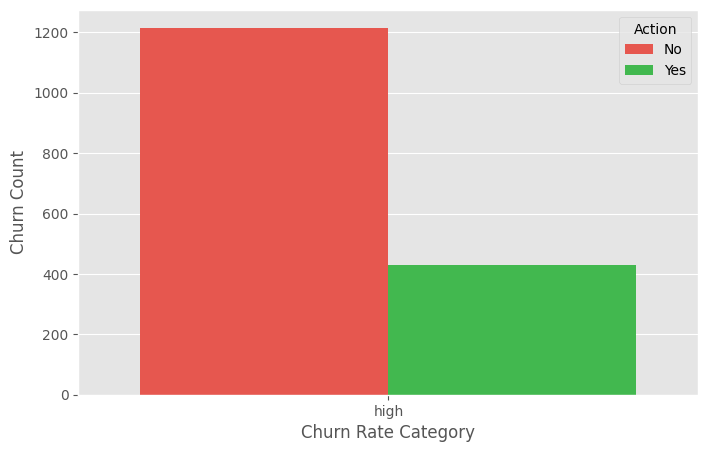

In [91]:

# Filter data for "high" Churn Rate Category

high_category_action = category_action[category_action["Churn Rate Category"] == "high"]

# Create a custom color palette
colors = ["#ff4136", "#2ecc40"]

# Plotting the graph
plt.figure(figsize=(8, 5))
sns.countplot(data=high_category_action, x="Churn Rate Category", hue="Action", palette=colors)
#plt.title("Churn Rate Category (High) vs. Action")
plt.xlabel("Churn Rate Category")
plt.ylabel("Churn Count")
plt.legend(title="Action", labels=["No", "Yes"])
plt.show()


####<-----------------------------------------------------------Code Ends Here-------------------------------------------------------->